# Understanding Weighted Directed Graphs for Polymer Implementation

## Table of Contents:
1. [Introduction](#introduction)
2. [Programmatic Conversion](#progconv)
3. [Weight and Direction Assignment](#wtassign)
4. [Data Composition](#datacompose)
5. [Graph Visualization](#datavis)
7. [Summary](#sum)
8. [Reference](#ref)

## 1. Introduction <a class="anchor" id="introduction"></a>

Everyday items such as water bottles, phone covers, and shoes are often made from synthetic polymers. The widespread use of polymers in various applications is due to their non-reactivity to external environments. This non-reactive property results in materials that are stress, thermal, and chemical tolerant, as well as highly stable, making them suitable for numerous use cases. The stability of polymers arises from the repetitive connection of identical molecules, resulting in minimal open bonds within the atom. This repetitive structure forms a chain-like architecture. From a chemical perspective, the formation and use of these molecules are relatively straightforward. However, their computational representation remains challenging and often fails to capture all aspects of the polymer.

In our previous tutorials, we discussed various representational mechanisms and their limitations (You can find the tutorial by clicking on this [link](https://deepchem.io/tutorials/an-introduction-to-the-polymers-and-their-representation/)). Another representation mechanism involves using weighted directed graphs, which includes stoichiometry, polymer types, and the direction and weight of the bonds. In this tutorial, we will delve into the weighted directed graph representation of polymers in detail.

Understanding the necessity of using weighted directed graphs is crucial. Other representational data types often rely on repetitive monomer representations to depict a complete polymer chain, which is inefficient and unrealistic. Basic graph datasets can represent a single repeating unit of one or more monomers. To emulate the repeating patterns of different monomers at various open bonds, weights and directions can be assigned to different connection sites. Thus, by incorporating weights and directions into a basic graph data type, we can efficiently manage the repeating architecture of polymers.

The basic unit of a polymer is the monomer. When monomers repeat in large numbers, they form a polymer chain. In some instances, a polymer chain can be composed of various types of monomers in different proportions. Such polymers are known as copolymers. To illustrate this concept more clearly, we will use an example of a copolymer and create a representation mechanism using a weighted directed graph data structure.

Let's take two monomer molecules. First given as SMILES notation `OB(O)c1cc(F)c(B(O)O)cc1F` and other one given as SMILES notation `Oc1cc(O)c(Br)c(O)c1Br`. For easier understanding, we can visualize it.

### Setup

In [ ]:
# installations
! pip install rdkit 

In [4]:
# all imports
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from matplotlib import pyplot as plt
import networkx as nx

### Code for visualization

In [5]:
def show_mols(mols: list, labels: list, figsize=(10,10)):
    """
    This function is used to display a list of molecules using matplotlib.
    """
    if len(mols) > 1: 
        fig, ax = plt.subplots(1, len(mols), figsize=figsize)
        for i in range(len(mols)):
            mol = mols[i]
            label = labels[i]
            img = Draw.MolToImage(mol)
            ax[i].imshow(img)
            ax[i].set_title(label)
            ax[i].axis('off')
            ax[i].set_aspect('equal')
    else:
        mol = mols[0]
        label = labels[0]
        img = Draw.MolToImage(mol)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

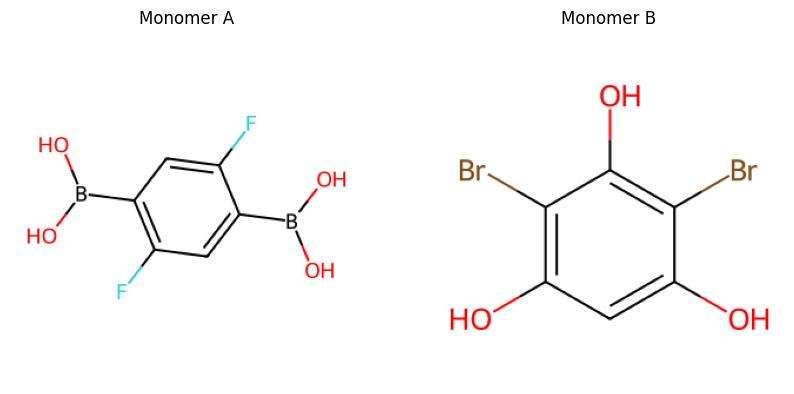

In [6]:
# loading monomer smiles as rdkit molecules
mA = "OB(O)c1cc(F)c(B(O)O)cc1F"
mB = "Oc1cc(O)c(Br)c(O)c1Br"
molA = Chem.MolFromSmiles(mA)
molB = Chem.MolFromSmiles(mB)

# showing the molecule
show_mols([molA, molB], ["Monomer A", "Monomer B"], figsize=(10,7))

The monomers depicted exhibit notable functional groups attached to their benzene rings. In monomer A, the functional group is boric acid, represented as  `B(O)O`, which consists of two hydroxyl `(OH)` groups bonded to a boron atom. This boric acid group is located at one end of the monomer. Additionally, fluorine `(F)` atoms are present as functional groups, but our focus will be on removing the boric acid group to create an open bond at that position.

In monomer B, bromine `(Br)` atoms are positioned at both ends of the benzene ring, serving as halogen functional groups. Although hydroxyl groups are also present around the benzene ring, the primary interest is in breaking the Br bonds to form open bonds. The most suitable sites for these modifications are clearly indicated in the figures provided below.

![monomerA](assets/polymer_images/monoA.png), ![monomerB](assets/polymer_images/monoB.png)

Once the functional groups to be removed for creating open bonds are identified, we can proceed by eliminating these groups and connecting the resultant open bonds to illustrate the resulting polymer. By combining two monomers through their respective open bonds, we effectively form a longer polymer chain through monomer conjunctions. For the time being, we can join two monomers at a specified open bond and represent the remaining open bonds with a virtual atom.

To achieve this, we will modify the SMILES string of the monomer by adding `At` to denote the virtual atom at the open bonds. To join two monomers at an open bond, we simply remove the functional groups at those positions and concatenate the SMILES strings. The resultant SMILES string and representation will be as follows:

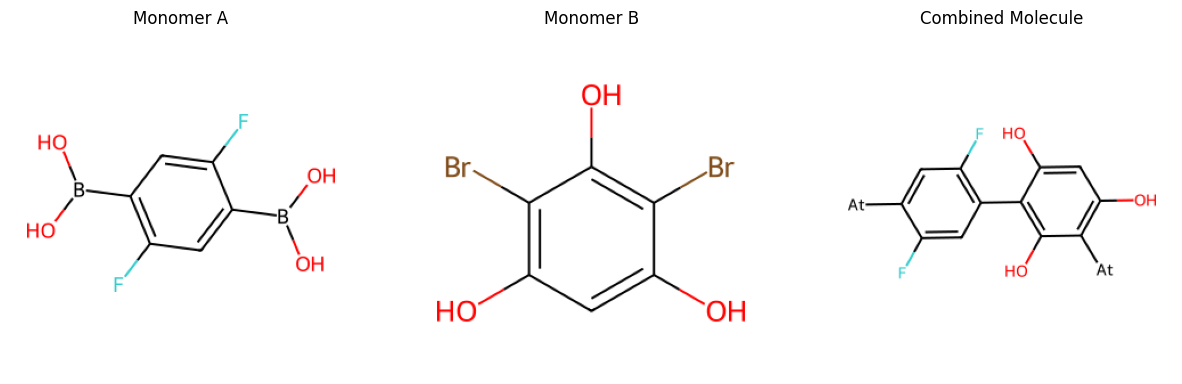

In [7]:
mAB = "[At]c1cc(F)c(c2c(O)c([At])c(O)cc2(O))cc1(F)"
molAB = Chem.MolFromSmiles(mAB)
show_mols([molA, molB, molAB], ["Monomer A", "Monomer B", "Combined Molecule"], figsize=(15,7))

Using intuition and general chemistry knowledge, we attempted to combine two monomers into a single representation, using a virtual atom to indicate the open connections. However, for practical implementation using code and logic, a conversion process must be developed. It should be noted that the virtual At atom does not fully represent the structural type of the polymer or the connection pattern with other monomers.

## 2. Programmatic Conversion <a id="progconv"></a>

To programmatically convert monomers into a single structure, we need to simulate the reaction process by eliminating the functional groups and marking the open bonds with indices. We will utilize SMILES Arbitrary Target Specification (SMARTS) to replicate the reaction and identify patterns within the molecules. The following steps outline the programmatic conversion process we will undertake.

1. Defining SMARTS notation to emulate the reaction
2. Gather resultant reactants and remove dupicate molecules
3. Return the modified molecule SMILES

For conversion of boric acid to open bonds The SMARTS (SMILES Arbitrary Target Specification) notation `[*:1]([B](-O)(-O))>>[*:1]-[*{i}]` is used (where `i` is an integer). Here's a breakdown of what each part of this notation means:

**Reactant Side**: `[*:1]([B](-O)(-O))`

`[*:1]`: This represents a wildcard atom (any atom) with a specific mapping label 1. The `[*]` notation means any atom, and :1 is a label used to map this atom to the product side of the reaction.
`([B](-O)(-O))`: This specifies a boron atom `[B]` with two hydroxyl groups attached (-O and -O).
This part of the notation is describing a generic atom connected to a boron atom with two hydroxyl groups. Essentially, it's looking for a structure in the molecule where any atom is bonded to a boric acid group.

**Reaction Arrow**: `>>`

The `>>` symbol separates the reactant (left side) from the product (right side) in the reaction notation.

**Product Side**: `[*:1]-[*{i}]`

`[*:1]`: This retains the wildcard atom with the mapping label 1 from the reactant side. It indicates that the atom with label 1 remains in the same place in the product.
`[*{i}]`: This represents a wildcard atom with an implicit hydrogen atom. The {i} indicates that the wildcard atom is implicit, meaning the hydrogen atom is not explicitly shown but is understood to be present.

Let's now code the transformation !

In [8]:
# utility functions to remove the duplicate molecules
def remove_duplicate_molecules(mols):
  '''
  This function is to remove duplicate molecules that are generated during
  the chemical reaction.
  Returns only the unique product molecules.
  '''
  smiles = list(set([Chem.MolToSmiles(m, canonical=True) for m in mols]))
  mols = [Chem.MolFromSmiles(s) for s in smiles]
  return mols

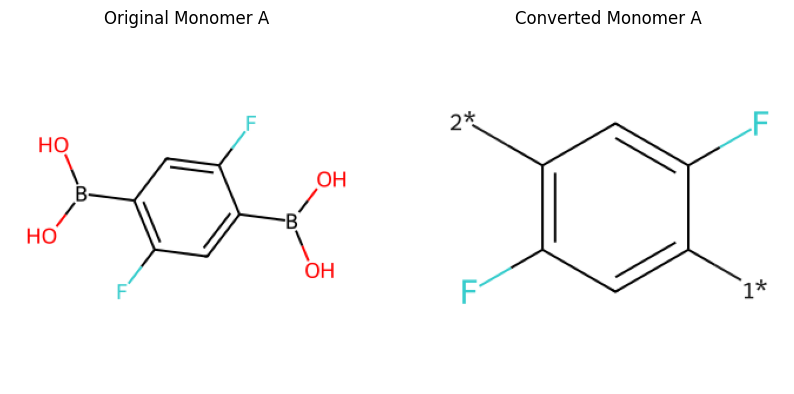

In [9]:
molA_s = molA # getting a copy of original monomer 
for i in [1,2]:
  smarts = f"[*:1]([B](-O)(-O))>>[*:1]-[*{i}]" # SMARTS to emulate reaction of B(O)O to open bond
  reaction = Chem.AllChem.ReactionFromSmarts(smarts)
  resultants = reaction.RunReactants((molA_s,))
  products = remove_duplicate_molecules([r[0] for r in resultants])
  molA_s = products[0]  # getting the main product of the reaction

show_mols([molA, molA_s], ["Original Monomer A", "Converted Monomer A"], figsize=(10,7))

According to above illustartaion, we can notice replacement of Boric Acid Group `(B(O)O)` with a corresponding index number. 

Similar process can be replicated in case of monomer B to replace "Br". The SMARTS notation that can emulate the replcement of bromine with corresponding atom index can be given as `[*:1]Br>>[*:1]-[*{i}]`. This SMARTS pattern `[*:1]Br>>[*:1]-[*{i}]` describes a chemical transformation where a bromine (Br) atom attached to any part of a molecule is replaced by a bond to an implicit atom `[*{i}]`. The `[*:1]` notation signifies any atom with an open bond, and the reaction arrow `>>` indicates the transformation. In summary, the bromine atom is replaced by a generic bonding site, denoted by `[*{i}]`, to indicate an open bond or a connection point for further reactions. The implementation is done in the following code block.

<a id="comb-img-sec"></a>

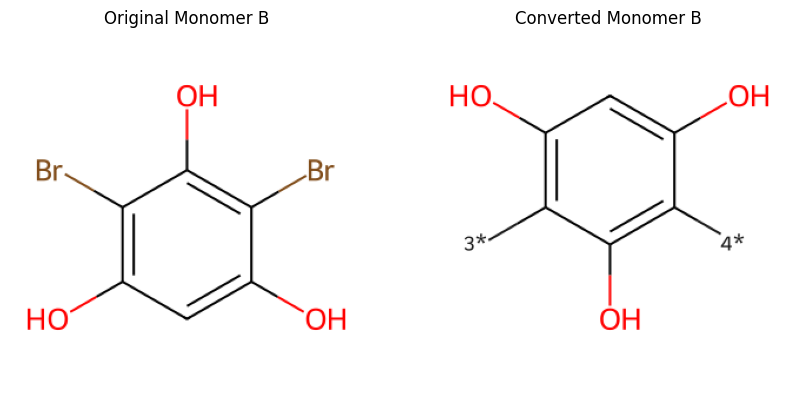

In [10]:
# there are potential two open bonds in our monomer B
molB_s = molB
for i in [3,4]:
  smarts = f"[*:1]Br>>[*:1]-[*{i}]" # SMARTS to emulate reaction of Br to open bond
  reaction = AllChem.ReactionFromSmarts(smarts)
  resultants = reaction.RunReactants((molB_s,))
  products = remove_duplicate_molecules([r[0] for r in resultants])
  molB_s = products[0]  # getting the main product of the reaction
  
show_mols([molB, molB_s], ["Original Monomer B", "Converted Monomer B"], figsize=(10,7))

This way we have replaced the Bromine with an indexed open bond where the polymer chain can connect to make a larger polymer molecule. To represent both monomers while keeping a valid SMILES, we can join both SMILES strings with a `.` in between and represent it as follows.

Combined AB SMILES: [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O


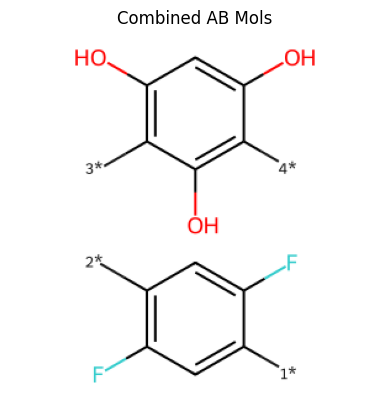

In [11]:
molA_smiles = Chem.MolToSmiles(molA_s)
molB_smiles = Chem.MolToSmiles(molB_s)
combined_AB_smiles = molA_smiles + "." + molB_smiles
combined_AB_mols = Chem.MolFromSmiles(combined_AB_smiles)
print("Combined AB SMILES:", combined_AB_smiles)
show_mols([combined_AB_mols],["Combined AB Mols"])

## 3. Weigths and Directions Assignment <a id="wtassign"></a>

In our previous steps, we developed a monomer wireframe capable of referencing different indexed open bonds to form various types of polymer chains. However, our goal is to condense the complete polymer chain architecture into a smaller yet robust representation using weights and directions. Weights can be assigned at two levels: to individual monomer atoms and to each bond. While the direction is generally consistent across different monomers, there is an edge case where a bond refers to itself (known as self-loop or self-edge in graphs), where an open bond connects with the same open bond of another monomer with an identical structure. For example, in the image below, the node labeled 0 is connected to itself by a self-edge.

![alt text](digraph.JPG)

##### Weight Assignment 

##### 1. Weight assignment to monomer elements


<a id="monomer-img"></a>
Polymers can be composed of monomers contributing in varying proportions. The proportion at which each monomer contributes corresponds to the weight of the elements of the respective monomer. The distribution of weights is generally straightforward. For instance, if `monomer A` and `monomer B` contribute to the polymer in a `3:1` ratio, the weights assigned to the elements of `monomer A` and `monomer B` are `0.75` and `0.25`, respectively. In this way, the contribution of each monomer fragment to the total polymer is represented by the weights of the nodes in the graph data.

However, the stoichiometry of the polymer can impose limitations on the weights assigned to the elements. For alternating polymers, where monomers are arranged in a pattern like "ABABAB...", the fraction of element A must be close to the fraction of element B. In other cases, such as block and random polymers, the fractions can vary and have different float values. ( For easier understanding you can refer to the image below ) These fractions are scientifically significant when calculating certain properties.

![alt text](1-s2.0-S0032386117300381-gr1.jpg)


<a id="atom-weight-show"></a>
For representational purpose we denote the weights of monomers with separator of "|". For example for alternating polymers the fragment weight should be represented as `|0.5|0.5|`.

##### 2. Weight assignment to bonds 

In the image above, we observe different stoichiometries of polymers. These arrangements significantly influence the properties of the polymer. Since we cannot replicate the complete repetition of the monomer, we must convert these stoichiometric constraints into edge weights in the node representation.

When determining a weight or fractional value for representation, we must divide the total contribution by the applied/effective contribution. The total contribution value can be confusing since not all monomers are included in the chain. Therefore, we will use the same fragment ratio used for assigning weights to the monomer elements. For instance, if the element fragments are in a 3:1 ratio, we will consider monomer arrangements in multiples of 4. For block polymer weight calculation, we would use "AAAABBBB".


#####   Calculating bond weights for different stoichiometry

> Weights for Alternating Polymer

For alternating polymers, the structure will resemble "ABABABAB." Consequently, monomers A and B will never connect to themselves, so the case of self-edges does not apply here. Considering the probability of occurrence, the bonds between A-B and B-A will each be assigned a weight of `0.5`.

Combined AB SMILES: [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O


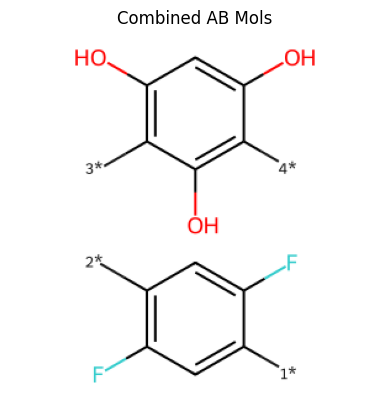

In [12]:
print("Combined AB SMILES:", combined_AB_smiles)
show_mols([combined_AB_mols],["Combined AB Mols"])

We represent the combination of atom indexes and bond weights for both forward and reverse bond formation as a single polymer rule, separated by colons. For example, if the weight of bond formation from A to B is 0.25 and from B to A is 0.75, it is represented as `1-2:0.25:0.75`. Multiple polymer rules are indicated by starting with a `<` and separating each rule similarly. For instance, `<1-2:0.5:0.5<3-4:0.25:0.75` signifies connections between index 1 open bond and index 2 open bond with a weight of 0.5, and between index 3 and index 4 with weights of 0.25 and 0.75 for forward and reverse bond formation, respectively.

For our example use case, there are four indexed open bonds, and self-edges are not present (i.e., 1-2 or 3-4 bonds cannot be formed). Therefore, the only possible bonds formed are 1-3, 1-4, 2-3, and 2-4. As previously determined, each bond will have a weight of 0.5.

Similar to above representation, we can reprsent the polymer rules for our example as follows.

`<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5`


In [13]:
# for alternate copolymer
alt_edge_content = [(1, 3, 1/2, 1/2),  # within A
                     (1, 4, 1/2, 1/2),  # within B
                     (2, 3, 1/2, 1/2),  # between A and B
                     (2, 4, 1/2, 1/2)]
alt_edge_string = "".join([f"<{e[0]}-{e[1]}:{e[2]}:{e[3]}" for e in alt_edge_content])
print("Polymer Rule String for alternate copolymer >>",alt_edge_string)

Polymer Rule String for alternate copolymer >> <1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5


> Weights for Block Polymers

Block copolymers are characterized by the segregation of monomer types into distinct domains. In a binary system, this can be simplified as a linear arrangement where identical monomers are consecutively linked, such as 'AAAABBBB'. Here, monomers A occupy one region while monomers B occupy another. A visual representation is provided in the accompanying [image](#monomer-img).

To model the weight distribution of an 'AAAABBBB' block copolymer, we represent it using eight monomer units. A total of eight bonds can be formed within this sequence. Six of these bonds are homogeneous (A-A or B-B), resulting in a bond probability and weight of 6/8. Conversely, only one heterogeneous bond (A-B) is possible, yielding a probability and weight of 1/8. The bond weight distribution based on atom indices is as follows:

- 1-2: 6/8
- 3-4: 6/8
- 1-3: 1/8
- 1-4: 1/8
- 2-3: 1/8
- 2-4: 1/8

This information can be converted into polymer rule format using the following code block.

In [20]:
# for block copolymer with no self edges
block_edge_content_wo_self_edges = [(1, 2, 6/8, 6/8),  # within A
                     (3, 4, 6/8, 6/8),  # within B
                     (1, 3, 1/8, 1/8),  # between A and B
                     (1, 4, 1/8, 1/8),
                     (2, 3, 1/8, 1/8),
                     (2, 4, 1/8, 1/8)]
block_no_self_edges_string = "".join([f"<{e[0]}-{e[1]}:{e[2]}:{e[3]}" for e in block_edge_content_wo_self_edges])
print("Polymer Rule String for Block without Self Edges >>",block_no_self_edges_string)

Polymer Rule String for Block without Self Edges >> <1-2:0.75:0.75<3-4:0.75:0.75<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125


If we consider self-edges (i.e. the same monomer structure connects to itself at same open bond) the probabilty weight between homogeneous bonds will be altered. For example the connection for A-A at index 1 can be at two open bonds i.e. 1-2 or 1-1 (self-edge) hence the previous probability will be halfed resulting to 3/8. Rest of the heterogenous bond weights will remain the same. So resulting weights will be as follows.

- 1-2: 3/8
- 1-1: 3/8
- 2-2: 3/8
- 3-4: 3/8
- 3-3: 3/8
- 4-4: 3/8
- 1-3: 1/8
- 1-4: 1/8
- 2-3: 1/8
- 2-4: 1/8

This information can be converted into polymer rule format using the following code block.

In [18]:
# for block copolymer with self edges
block_edge_content = [(1, 2, 3/8, 3/8),  # within A
        (1, 1, 3/8, 3/8),
        (2, 2, 3/8, 3/8),
        (3, 4, 3/8, 3/8),  # within B
        (3, 3, 3/8, 3/8),
        (4, 4, 1/8, 1/8),
        (1, 3, 1/8, 1/8),  # between A and B
        (1, 4, 1/8, 1/8),
        (2, 3, 1/8, 1/8),
        (2, 4, 1/8, 1/8)]
block_edges_string = "".join([f"<{e[0]}-{e[1]}:{e[2]}:{e[3]}" for e in block_edge_content])
print("Polymer Rule String for Block with Self Edges >>", block_edges_string)

Polymer Rule String for Block with Self Edges >> <1-2:0.375:0.375<1-1:0.375:0.375<2-2:0.375:0.375<3-4:0.375:0.375<3-3:0.375:0.375<4-4:0.125:0.125<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125


> Weights for Random Polymer

The weight calculation for a random polymer chain is straightforward. Without self-edges, any indexed bond can connect to another open bond of the same monomer (e.g., 1-2 or 2-1) with a probability of 1/2. Similarly, any indexed bond connecting with an indexed open bond of another monomer type (e.g., 1-3, 1-4, 2-3, 2-4) has a probability of 1/3. When considering self-edges, every indexed bond can connect with every other indexed bond (i.e., at 4 possible bonding sites), resulting in a probability weight of 1/4. (Refer to [this](#comb-img-sec) section for more clarification) Thus, with or without self-edges, we can determine the following weight distribution.

With self-edge:
- 1-1 -> 0.25
- 1-2 -> 0.25
... (same for all bond connection)

Without self-edge:
- 1-2 -> 0.5
- 3-4 -> 0.5
- 1-3 -> 0.33
- 1-4 -> 0.33
- 2-3 -> 0.33
- 2-4 -> 0.33

In [14]:
# for random copolymer with self edges
possible_bond_site_indexes = [1,2,3,4]
random_edge_content = []
for i in possible_bond_site_indexes:
        for j in possible_bond_site_indexes:
                random_edge_content.append([i,j,1/4,1/4])
random_edges_string = "".join([f"<{e[0]}-{e[1]}:{e[2]}:{e[3]}" for e in random_edge_content])
print("Polymer Rule String for Block with Self Edges >>", random_edges_string)

Polymer Rule String for Block with Self Edges >> <1-1:0.25:0.25<1-2:0.25:0.25<1-3:0.25:0.25<1-4:0.25:0.25<2-1:0.25:0.25<2-2:0.25:0.25<2-3:0.25:0.25<2-4:0.25:0.25<3-1:0.25:0.25<3-2:0.25:0.25<3-3:0.25:0.25<3-4:0.25:0.25<4-1:0.25:0.25<4-2:0.25:0.25<4-3:0.25:0.25<4-4:0.25:0.25


In [15]:
# for block copolymer without self edges
random_edge_content_wo_self_edge = [(1, 2, 1/2, 1/2),  # within A
        (3, 4, 1/2, 1/2),  # within B
        (1, 3, 1/3, 1/3),  # between A and B
        (1, 4, 1/3, 1/3),
        (2, 3, 1/3, 1/3),
        (2, 4, 1/3, 1/3)]
random_edges_wo_self_edge_string = "".join([f"<{e[0]}-{e[1]}:{e[2]:.2f}:{e[3]:.2f}" for e in random_edge_content_wo_self_edge])
print("Polymer Rule String for Block without Self Edges >>", random_edges_wo_self_edge_string)

Polymer Rule String for Block without Self Edges >> <1-2:0.50:0.50<3-4:0.50:0.50<1-3:0.33:0.33<1-4:0.33:0.33<2-3:0.33:0.33<2-4:0.33:0.33


In this manner, we can add weights to different components of the graph data.

## 4. Data Composition<a id='datacompose'></a>

In our previous steps, we created a wireframe for monomers with indexed open bonds and calculated the weights for bonds and elements based on stoichiometry and monomer fragment distribution. Now, we need to integrate all these data representations into a single string format to construct a weighted directed graph in one go. We have information in three three parts now.
 
1. The indexed monomer wireframe
2. Assigned weights to elements
3. Polymer rules containing polymer weights mapped with direction

Considering easier understanding and processing, we concatenate these three parts into a single string. In our case, we have a monomer indexed representation of two monomers given as `[1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O`. For the second part the fractions of the two monomers were asssigned to be 0.5 for each. As per the representation we mentioned in weight assignment to bond [section](#atom-weight-show), it can be written as `|0.5|0.5|`.

Finally, in the polymer rules section, there could be three variations of the same monomer corresponding to different stoichiometries. For each monomer example considered, there can be at least three types (i.e., Alternating, Block, and Random). Each type will have a different polymer rules string concatenated, resulting in different string representations from the same monomer string. We can achieve this using the following code block.

*Note - There could be different cases, if there is self-edge possible for monomer stoichiomentry.*

In [16]:
# for our example 
monomer_fragment_string = "|0.5|0.5|"
poly_wireframe_w_weights = combined_AB_smiles + monomer_fragment_string
print("Repeatable weighted base representation >>", poly_wireframe_w_weights)

Repeatable weighted base representation >> [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|


Once we have the base string representation, we will append the polymer rule strings to the end of the base string. Since the polymer rules for this polymer have already been determined in previous code blocks, we will use those strings to construct the final string.

> Without self-edges

In [21]:
polymer_alternate = poly_wireframe_w_weights + alt_edge_string
polymer_block = poly_wireframe_w_weights + block_no_self_edges_string
polymer_random = poly_wireframe_w_weights + random_edges_wo_self_edge_string
print("The string representation of alternating polymer >>", polymer_alternate)
print("The string representation of block polymer >>", polymer_block)
print("The string representation of random polymer >>", polymer_random)

The string representation of alternating polymer >> [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5
The string representation of block polymer >> [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-2:0.75:0.75<3-4:0.75:0.75<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125
The string representation of random polymer >> [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-2:0.50:0.50<3-4:0.50:0.50<1-3:0.33:0.33<1-4:0.33:0.33<2-3:0.33:0.33<2-4:0.33:0.33


> With self-edges

In case of self-edges, alternating polymer is not possible. We can include remaining cases of random and block polymer to form a string representation as follows.

In [22]:
polymer_block_w_self_edge = poly_wireframe_w_weights + block_edges_string
polymer_random_w_self_edge = poly_wireframe_w_weights + random_edges_string 
print("The string representation of block polymer with self-edge >>", polymer_block_w_self_edge)
print("The string representation of random polymer wth self-edge >>", polymer_random_w_self_edge)

The string representation of block polymer with self-edge >> [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-2:0.375:0.375<1-1:0.375:0.375<2-2:0.375:0.375<3-4:0.375:0.375<3-3:0.375:0.375<4-4:0.125:0.125<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125
The string representation of random polymer wth self-edge >> [1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-1:0.25:0.25<1-2:0.25:0.25<1-3:0.25:0.25<1-4:0.25:0.25<2-1:0.25:0.25<2-2:0.25:0.25<2-3:0.25:0.25<2-4:0.25:0.25<3-1:0.25:0.25<3-2:0.25:0.25<3-3:0.25:0.25<3-4:0.25:0.25<4-1:0.25:0.25<4-2:0.25:0.25<4-3:0.25:0.25<4-4:0.25:0.25


These data string representations are not widely adopted, as the use of weighted directed graphs in these fields is relatively recent and specifically compatible with Weighted Directed Message Passing Neural Networks (w-DMPNN). However, this string representation effectively stores all the necessary data to form a valid weighted directed graph structure from polymer data. Unlike other representations where polymer tasks may fail, this representation significantly enhances the accuracy of polymer representation and training.

## 5. Graph Visualization<a id="datavis"></a>

Although we have all the necessary data within a string representation, we have not yet formed a weighted directed graph. Creating the weighted directed graph from this representation will be part of the featurization process. For our convenience, we will convert this string data into a graph object and visualize it. Converting the graph data is straightforward once the string format is parsed.

1. The first part of the representation is used to form a simple graph by assigning elements to nodes and bonds to edges.
2. The second part of the representation provides the weights for the monomer elements.
3. The third part of the representation assigns direction and weights to the formed bonds.

*Note - We have to setup a logic to handle the reverse bond as well.*

The following code block implements above steps. ( For better visualization, we are adding color annotation to element nodes )

In [23]:
def rev_bonds(bond_str):
  """creates reverse bonds of the existing bonds between open bonds"""
  rev_str = str(bond_str.split("-")[-1])+"-"+str(bond_str.split("-")[0])
  return rev_str

# creating colour mapping for different atoms
COLOR_MAPPER ={
    "C" : "green",
    "F" : "blue" ,
    "O" : "yellow"
}


def smiles_to_graph(smiles_string):
    """Converts a SMILES string to a weighted, directed NetworkX graph."""

    # >>> Parsing the string values to different segments

    # Split the SMILES string by the pipe (|) delimiter
    parts = smiles_string.split('|')
    node_colors = []

    # Extract the SMILES representation of monomers (before the pipe)
    monomer_smiles = parts[0]

    # Extracting connection bond details from string representation
    bonds_strs= parts[-1].split("<")[1:]

    # >>> Structuring the input properly 

    # creating dictionary of bonds in both directions
    bond_dict={ k.split(":")[0]: k.split(":")[1] for k in bonds_strs }
    rev_bond_dict={ rev_bonds(bond_val):bond_wei for (bond_val,bond_wei) in bond_dict.items() }
    bond_dict.update(rev_bond_dict)

    node_labels = {}

    # >>> Handling graph generation and weight assignment 

    # Create an empty directed graph
    G = nx.DiGraph()

    # Process the monomer SMILES string using RDKit
    mol = Chem.MolFromSmiles(monomer_smiles)
    atoms = mol.GetAtoms()

    updater = 1

    # Add nodes to the graph based on atom indices
    for atom in atoms:
      if (atom.GetSymbol() == "*"):
        # adding wild card atoms and assigning labels with it
        G.add_node(atom.GetIdx())
        node_labels[atom.GetIdx()] = f"*{updater}"
        node_colors.append("gray")
        updater += 1
      else:
        G.add_node(atom.GetIdx())
        node_labels[atom.GetIdx()] = f"{atom.GetSymbol()}"
        node_colors.append(COLOR_MAPPER[f"{atom.GetSymbol()}"])



    # Process edges (bonds) and weights
    for bond in mol.GetBonds():
        source = bond.GetBeginAtomIdx()
        target = bond.GetEndAtomIdx()
        G.add_edge(source, target, weight=1.0, label="1.0")
        G.add_edge(target, source, weight=1.0, label="1.0")

    # assigning new connected edges to the graph
    for bond_val, wei_val in bond_dict.items():
      start = "*"+bond_val.split("-")[0]
      end = "*"+bond_val.split("-")[1]
      start_idx, end_idx = None,None
      for idx,val in node_labels.items():
        if val == start:
          start_idx = idx
        elif val == end:
          end_idx = idx
      # handling self edge case
      if start == end and start != None:
        G.add_edge(start_idx,start_idx, weight=wei_val, label=f"{wei_val}")
      else:
        if start_idx == None: raise ValueError(f"Index not found for start wildcard {start}")
        if end_idx == None: raise ValueError(f"Index not found for end wildcard {end}")
        G.add_edge(start_idx,end_idx, weight=wei_val, label=f"{wei_val}")


    return G, node_labels, node_colors

In the above function we are parsing and processing the representation string in following steps.

1. In the initial step, we obtain the indexed SMILES representation by parsing the first element using the "|" separator.

2. We then extract the fractions from the first and second elements of the parsed list.

3. The last element is the string representing the polymer rules, from which we extract the index and weight of the bonds.

4. A directional graph is initialized, and the element data is assigned as node values.

5. Initially, bonds from the SMILES string are added with weights of 1.

6. Finally, the indexed bonds from the polymer rules are added to the main graph.

Along with the formation of the graph object, labels and color annotations were added to facilitate distinct representations. In the following code snippet, we will set up a function to generate the graph display it.

In [32]:
def draw_graph(smiles_string, figsize=(8,8)):
  """This function draws the graph with edge-labels and colors"""
  G, node_labels, node_colors  = smiles_to_graph(smiles_string)

  plt.figure(figsize=figsize)
  # Create visual representation using Matplotlib and NetworkX
  pos = nx.spring_layout(G)  # Use a layout algorithm
  # node_labels = {node: node for node in G.nodes()}

  # Customize edge labels to display weights
  edge_labels = {(source, target): data['label'] for source, target, data in G.edges.data()}

  nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_shape='o')
  nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=True, width=2, alpha=0.7, edge_color="black")
  nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

  plt.axis('off')
  plt.show()

Now as we have completed the functions for graph formation and visualization, we can form the graph and show it from our string representation.  

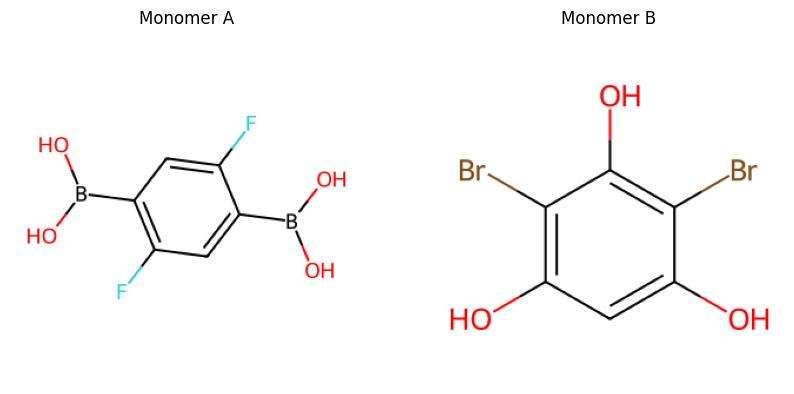

In [26]:
show_mols([molA, molB], ["Monomer A", "Monomer B"], figsize=(10,7))

For Reference above is our input monomer molecules and below are the graph representations of different stoichiometry for the resultant polymer.

> Graph representation for polymer variations 

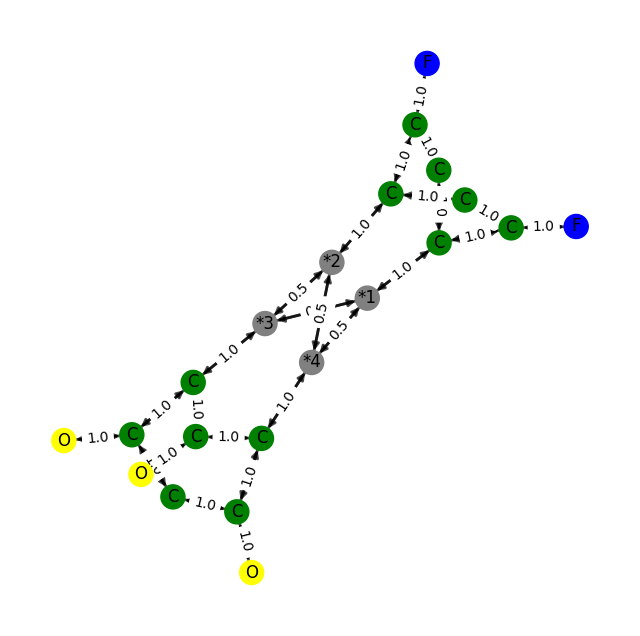

In [33]:
draw_graph(polymer_alternate)

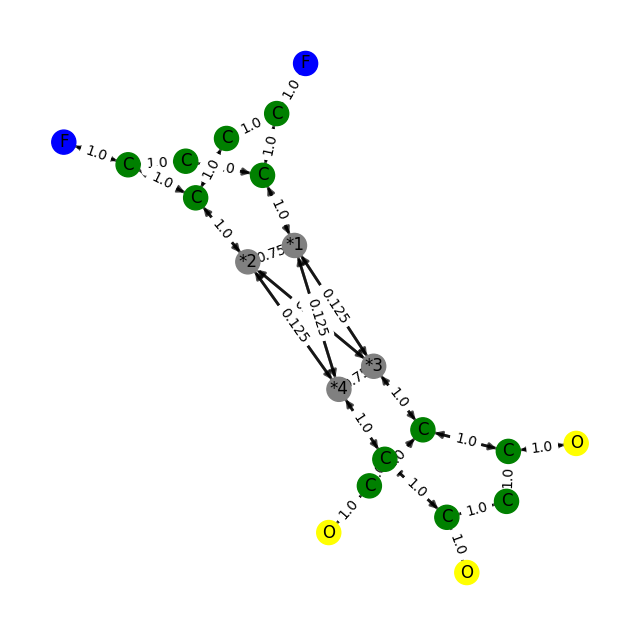

In [34]:
draw_graph(polymer_block)

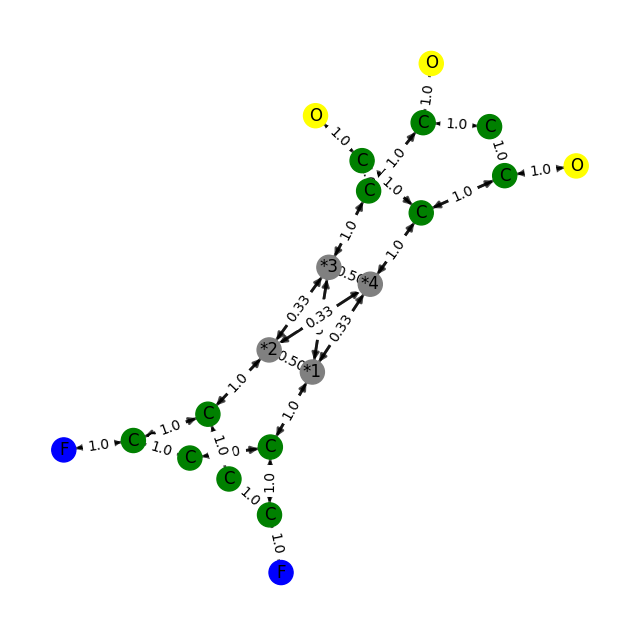

In [37]:
draw_graph(polymer_random)

> Graph representation for polymer variations with self-edge 

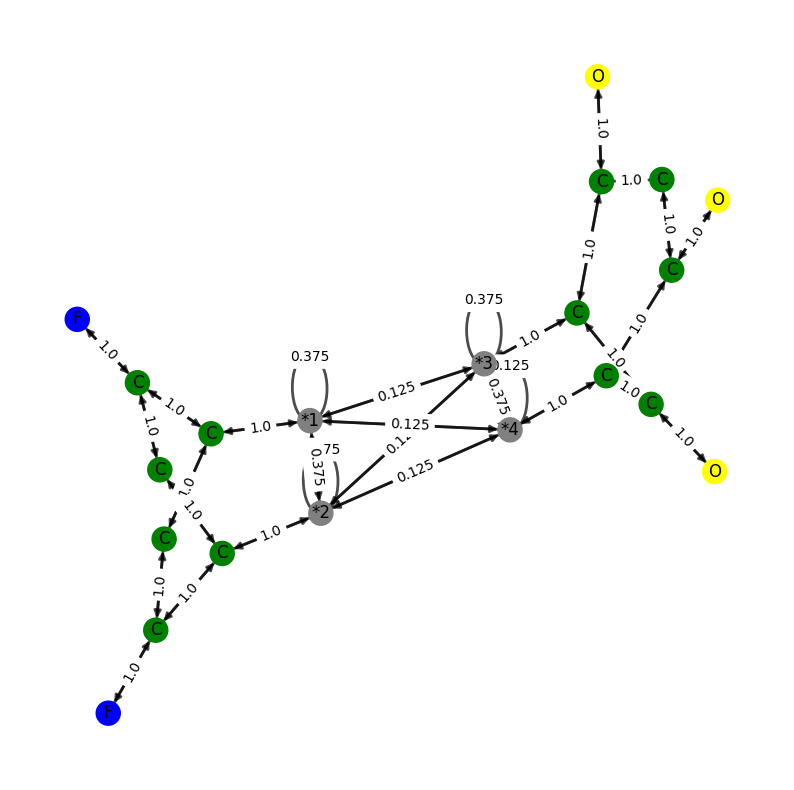

In [39]:
draw_graph(polymer_block_w_self_edge, figsize=(10,10))

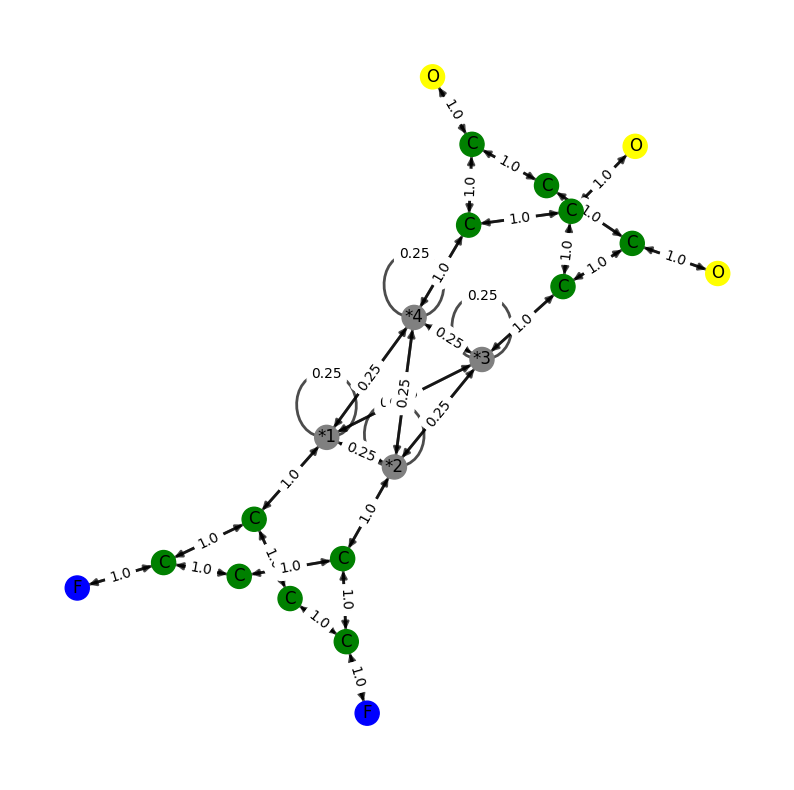

In [43]:
draw_graph(polymer_random_w_self_edge, figsize=(10,10))

In this manner we converted monomer SMILES into different polymer graphs based on the stoichiometry variations.

## 7. Summary <a id="sum"></a>

- **Representation of Polymers as Graphs**
    
    > Explored the use of weighted directed graphs to represent polymers, offering a detailed and efficient method compared to traditional approaches.
- **Graph Weighting and Directionality**
    
    > Assigned weights and directions to graphs to reflect monomer proportions and bonding patterns, capturing the stoichiometry and structural constraints of different polymer types.
- **Handling Diverse Polymer Architectures**
    
    > Addressed the representation of various polymer architectures, including alternating, block, and random copolymers, and managed complex structures with self-edges and diverse bonding patterns.
- **Polymer Rule Strings**
    
    > Developed a systematic approach to translate polymer structures into polymer rule strings, laying the foundation for accurate and efficient modeling of polymer properties and behaviors.
- **Visualization and Conversion Techniques**
    
    > Utilized `RDKit` and `NetworkX` for visualizing monomer structures and developed methods to convert monomers into graph-based representations.

## 8. Reference <a id="ref"></a>

This work is inspired by the research findings of following research paper.

1. [Aldeghi, Matteo, and Connor W. Coley. "A graph representation of molecular ensembles for polymer property prediction." Chemical Science 13.35 (2022): 10486-10498.](https://pubs.rsc.org/en/content/articlehtml/2022/sc/d2sc02839e)

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Citing This Tutorial
If you found this tutorial useful please consider citing it using the provided BibTeX.

In [ ]:
@manual{Intro1,
 title={Understanding Weighted Directed Graphs for Polymer Implementation},
 organization={DeepChem},
 author={Mohanty, Debasish},
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Understanding_WDGraphs_for_polymers.ipynb}},
 year={2024},
}